<a href="https://colab.research.google.com/github/taareek/neural_netwok/blob/main/NN_Assignment_5b_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Enabling GPU*

In [128]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


*Importing necessary libraries*

In [129]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

*Downloading CIFAR-10 Dataset*

In [130]:
# number of subprocesses to use for data loading
num_workers = 0
batch_size = 20
# percentage of training set to use as validation (here I have used 20%)
valid_size = 0.2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

print('Training set samples:', len(train_data))
print('Test set samples:', len(test_data))



Files already downloaded and verified
Files already downloaded and verified
Training set samples: 50000
Test set samples: 10000


*Splitting Training and Test Data into train, validation and test set*

In [131]:
num_train = len(train_data)
indices = list(range(num_train))
print(len(indices))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
#print(split)
train_idx, valid_idx = indices[split:], indices[:split]
print(len(train_idx))
for i in range(10):
  print(train_idx[i])

50000
40000
12967
40651
17476
44570
34536
4729
47300
19711
6785
26143


In [132]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

*Visualize Training data (1 batch)*

In [133]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

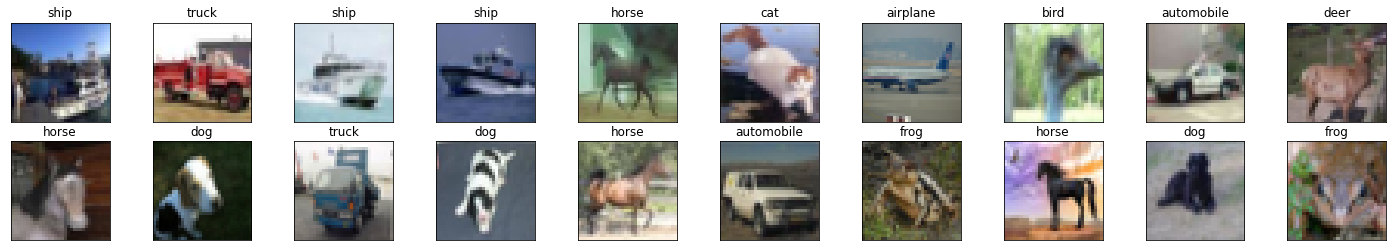

In [134]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

***Defining CNN Model***

In [135]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, kernel_size= 3, padding=1)
        # convolutional layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size= 3, padding=1)
        # convulation layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 1000)
        # linear layer (1000 -> 500)
        self.fc2 = nn.Linear(1000, 500)
        # linear layer (500 -> 10)
        self.fc3 = nn.Linear(500,10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # adding sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with sigmoid activation function
        x = F.sigmoid(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with sigmoid activation function
        x = F.sigmoid(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd layer
        x = self.fc3(x)
        return x

In [136]:
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


*Loss function and optimizer*

In [137]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 5e-4)

***Training our Model***

In [139]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 2.322675 	Validation Loss: 2.314074
Validation loss decreased (inf --> 2.314074).  Saving model ...
Epoch: 2 	Training Loss: 2.317036 	Validation Loss: 2.312161
Validation loss decreased (2.314074 --> 2.312161).  Saving model ...
Epoch: 3 	Training Loss: 2.315197 	Validation Loss: 2.306584
Validation loss decreased (2.312161 --> 2.306584).  Saving model ...
Epoch: 4 	Training Loss: 2.311912 	Validation Loss: 2.309662
Epoch: 5 	Training Loss: 2.310520 	Validation Loss: 2.306035
Validation loss decreased (2.306584 --> 2.306035).  Saving model ...
Epoch: 6 	Training Loss: 2.308229 	Validation Loss: 2.302154
Validation loss decreased (2.306035 --> 2.302154).  Saving model ...
Epoch: 7 	Training Loss: 2.305275 	Validation Loss: 2.296641
Validation loss decreased (2.302154 --> 2.296641).  Saving model ...
Epoch: 8 	Training Loss: 2.256763 	Validation Loss: 2.161375
Validation loss decreased (2.296641 --> 2.161375).  Saving model ...
Epoch: 9 	Training Loss: 2.084835 

*Load model with minimum loss*

In [140]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

*Test the train Network And Accuracy*

In [141]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test Loss: 0.826356

Test Accuracy of airplane: 69% (691/1000)
Test Accuracy of automobile: 85% (851/1000)
Test Accuracy of  bird: 56% (560/1000)
Test Accuracy of   cat: 64% (640/1000)
Test Accuracy of  deer: 56% (569/1000)
Test Accuracy of   dog: 50% (507/1000)
Test Accuracy of  frog: 76% (765/1000)
Test Accuracy of horse: 79% (797/1000)
Test Accuracy of  ship: 87% (878/1000)
Test Accuracy of truck: 83% (836/1000)

Test Accuracy (Overall): 70% (7094/10000)


*Visualize Test results with sample*

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


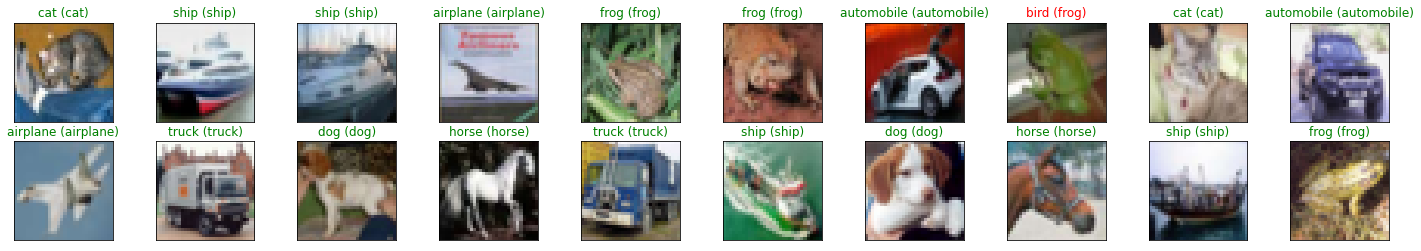

In [142]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

***Confusion Matrix***

In [143]:
print(len(train_data))
print(len(train_data.targets))

50000
50000


In [144]:
# Function for prediction
# Doesn't work in our scenario
@torch.no_grad()
def get_all_preds(cnn_model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = cnn_model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [192]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [193]:
# Function for prediction
# It works!
@torch.no_grad()
def prediction(cnn, batch_loader):
  total_preds = torch.tensor([]).cuda()
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # convert output probabilities to predicted class
    _,pred = torch.max(output, 1) 
    total_preds = torch.cat(
            (total_preds, output)
            ,dim=0
        )
  return total_preds

In [194]:
#test_prediction_loader = torch.utils.data.DataLoader(test_data, batch_size=20)
with torch.no_grad():
    test_prediction_loader = torch.utils.data.DataLoader(test_data, batch_size=20)
    test_preds = prediction(model, test_prediction_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [195]:
len(test_preds)

10000

In [198]:
test_preds = test_preds.cpu()
conf_matrix = confusion_matrix(test_data.targets, test_preds.argmax(dim= 1))
print(conf_matrix)

[[691  27  50  23   6   4   3  13 121  62]
 [  9 851   1   7   1   2   3   2  28  96]
 [ 76  11 560 105  59  45  52  53  22  17]
 [ 17  12  52 640  35 101  45  48  17  33]
 [ 20   3  86 114 569  25  48 113  13   9]
 [ 12   5  42 295  25 507  10  76  12  16]
 [  5   7  43 107  29   9 765   5  13  17]
 [ 14   5  25  63  28  38   3 797   8  19]
 [ 28  37   6  16   1   3   2   3 878  26]
 [ 10  88   4  21   2   4   1   8  26 836]]


Confusion matrix, without normalization


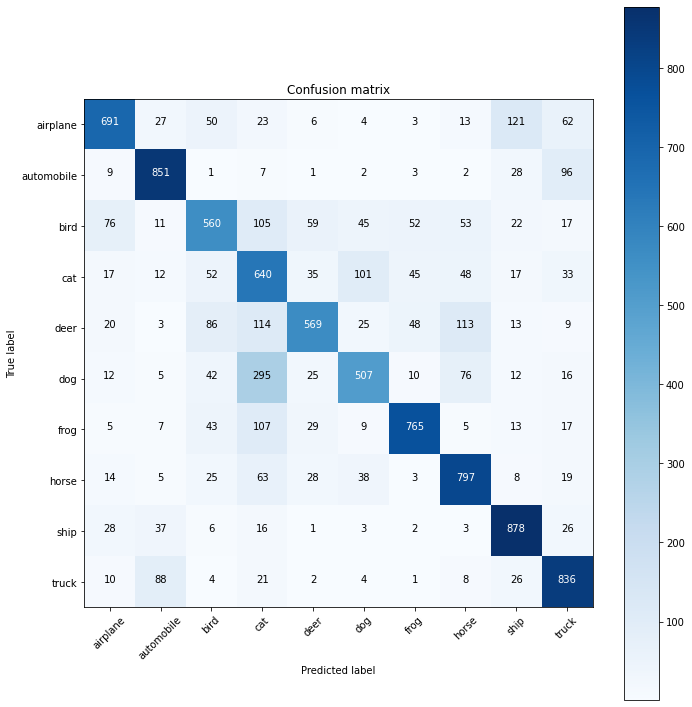

In [197]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix, train_data.classes)

# Draft

In [160]:
len(train_preds)
print(train_preds[3])

tensor([ 0.0464,  0.0321,  0.6740,  0.2034, -0.3273,  0.0766,  0.3750,  0.3106,
        -0.2834,  0.3333])


In [19]:
# Function to get number correct classification
# jhamela ache ekahne

def get_num_correct(preds, labels):
  num_correct = 0
  for i in range(len(preds)):
    preds_label = preds[i].argmax()
    if preds_label == labels[i]:
      num_correct+= 1
  return num_correct


In [29]:
# Predictions on train data
model1 = Net()
model1 = model1.cpu() # moving our model to CPU as we trained our model in GPU
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=20)
    train_preds = get_all_preds(model1, prediction_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [30]:
# Getting accuracy on train data
preds_correct = get_num_correct(train_preds, train_data.targets)
print("Total corrects: ", preds_correct)
print("Accuracy: ", (preds_correct/ len(train_data.targets)) *100)

Total corrects:  4985
Accuracy:  9.969999999999999


In [31]:
for i in range(5):
  print(train_preds[i])

tensor([ 0.1023,  0.5309,  0.9629, -0.0568, -0.1206, -0.2918,  0.2548,  0.4906,
        -0.3196, -0.0019])
tensor([ 0.2161,  0.0955,  0.9204, -0.0459, -0.3321, -0.1419, -0.0113,  0.3711,
        -0.2925,  0.0858])
tensor([ 0.3101, -0.0921,  0.8460,  0.1361, -0.3745,  0.1984,  0.3655, -0.0416,
         0.1336,  0.0707])
tensor([ 0.2471,  0.1450,  0.5735,  0.1945, -0.4120,  0.0687,  0.1969,  0.1027,
        -0.1359,  0.1466])
tensor([ 0.3683,  0.2769,  0.8806,  0.1002, -0.3488, -0.0588, -0.0721,  0.4447,
        -0.2287, -0.0722])


In [32]:
 # Prediction on test data
 with torch.no_grad():
    test_prediction_loader = torch.utils.data.DataLoader(test_data, batch_size=20)
    test_preds = get_all_preds(model, test_prediction_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
# Getting accuracy on Test data
test_preds_correct = get_num_correct(test_preds, test_data.targets)
print("Total corrects: ", test_preds_correct)
print("Accuracy: ", (test_preds_correct/ len(test_data.targets)) *100)

Total corrects:  1038
Accuracy:  10.38


In [122]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

In [123]:
cm = confusion_matrix(train_data.targets, train_preds.argmax(dim=1))

In [124]:
print(type(cm))

<class 'numpy.ndarray'>


In [125]:
cm

array([[  63,   35, 4747,    7,    0,    5,   27,  102,    1,   13],
       [  67,   41, 4701,   11,    0,    6,   46,  115,    2,   11],
       [  84,   40, 4713,   12,    0,    8,   28,  103,    2,   10],
       [  70,   45, 4707,    8,    0,    7,   35,  113,    2,   13],
       [  74,   34, 4685,   12,    0,   10,   33,  133,    3,   16],
       [  63,   34, 4702,   10,    0,    8,   30,  143,    0,   10],
       [  64,   29, 4743,   12,    0,    6,   39,   98,    0,    9],
       [  68,   26, 4730,   13,    0,    3,   37,  109,    0,   14],
       [  78,   34, 4715,    9,    0,    4,   26,  123,    1,   10],
       [  77,   39, 4722,   13,    0,    3,   25,  115,    3,    3]])

In [126]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  63   35 4747    7    0    5   27  102    1   13]
 [  67   41 4701   11    0    6   46  115    2   11]
 [  84   40 4713   12    0    8   28  103    2   10]
 [  70   45 4707    8    0    7   35  113    2   13]
 [  74   34 4685   12    0   10   33  133    3   16]
 [  63   34 4702   10    0    8   30  143    0   10]
 [  64   29 4743   12    0    6   39   98    0    9]
 [  68   26 4730   13    0    3   37  109    0   14]
 [  78   34 4715    9    0    4   26  123    1   10]
 [  77   39 4722   13    0    3   25  115    3    3]]


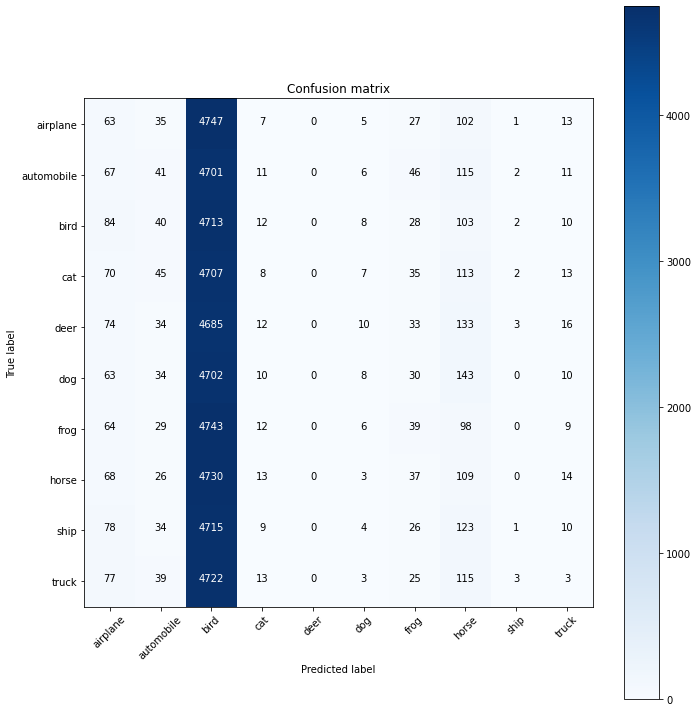

In [127]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_data.classes)